In [ ]:
# Install TensorFlow package
!pip install tensorflow

In [ ]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [ ]:
!unzip E-Wasteclassificationdataset.zip

Archive:  E-Wasteclassificationdataset.zip
  inflating: modified-dataset/test/Battery/battery_106.jpg  
  inflating: modified-dataset/test/Battery/battery_128.jpg  
  inflating: modified-dataset/test/Battery/battery_148.jpg  
  inflating: modified-dataset/test/Battery/battery_152.jpg  
  inflating: modified-dataset/test/Battery/battery_174.jpg  
  inflating: modified-dataset/test/Battery/battery_177.jpg  
  inflating: modified-dataset/test/Battery/battery_190.jpg  
  inflating: modified-dataset/test/Battery/battery_192.jpg  
  inflating: modified-dataset/test/Battery/battery_211.jpg  
  inflating: modified-dataset/test/Battery/battery_22.jpg  
  inflating: modified-dataset/test/Battery/battery_24.jpg  
  inflating: modified-dataset/test/Battery/battery_241.jpg  
  inflating: modified-dataset/test/Battery/battery_242.jpg  
  inflating: modified-dataset/test/Battery/battery_251.jpg  
  inflating: modified-dataset/test/Battery/battery_259.jpg  
  inflating: modified-dataset/test/Battery/b

In [ ]:
testpath= r'/content/modified-dataset/test'
trainpath= r'/content/modified-dataset/train'
validpath = r'/content/modified-dataset/val'

In [ ]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [ ]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


### Visualize sample images from each class.

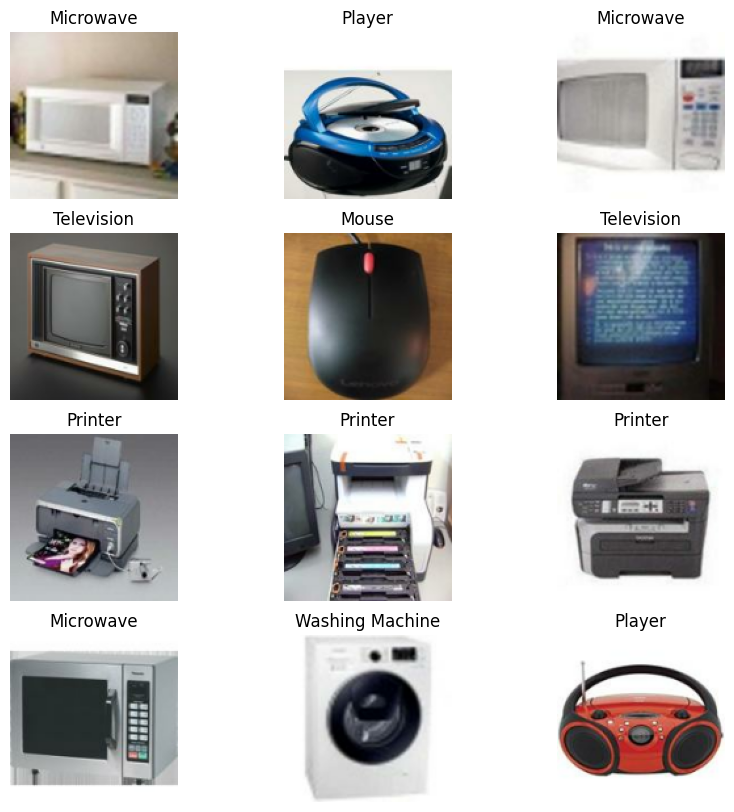

In [ ]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting inside the function
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


In [ ]:
# Prepare data for plotting
class_names = list(class_counts.keys())  # List of class names
counts = list(class_counts.values())     # Corresponding counts for each class


In [ ]:
import matplotlib.pyplot as plt

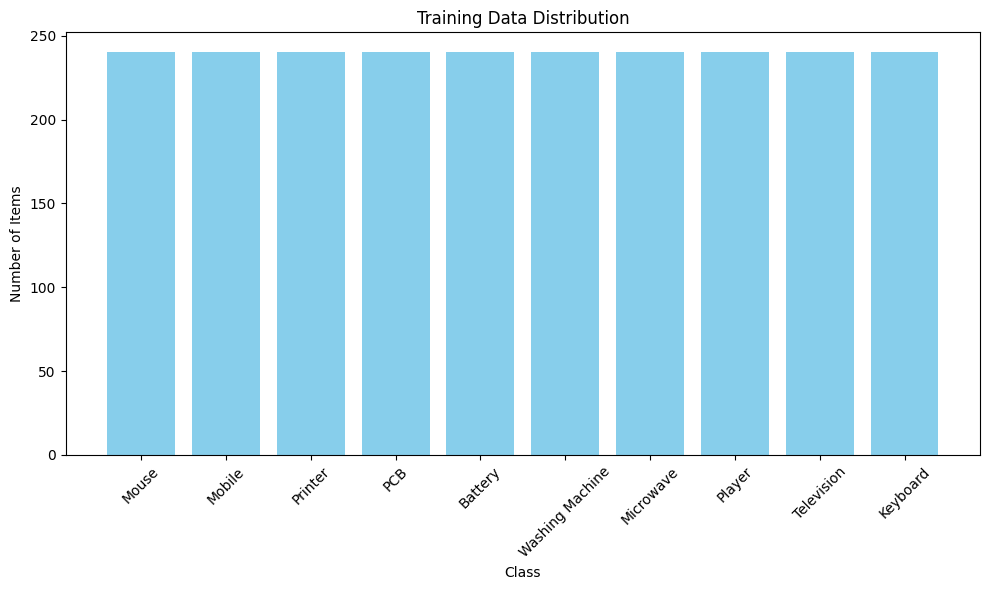

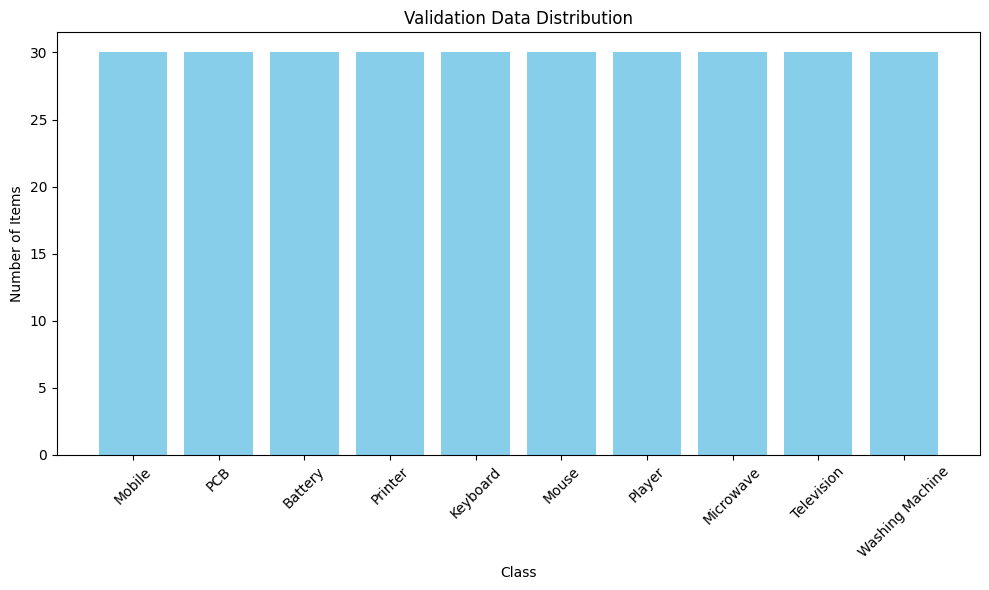

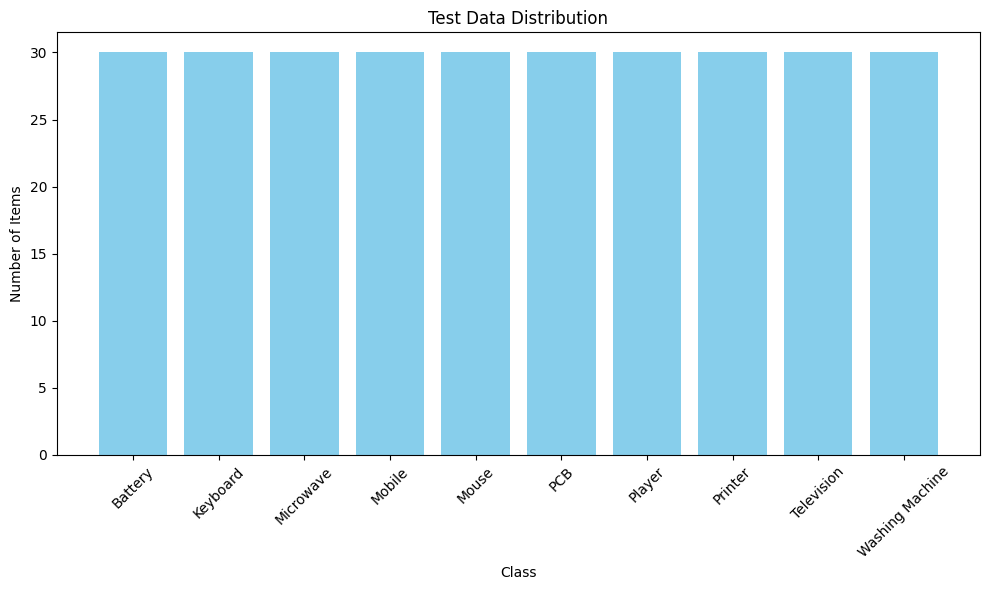

In [ ]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [ ]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
X_train = np.random.rand(1000, 28, 28)
y_train = np.random.randint(0, 10, size=(1000,))
X_valid = np.random.rand(200, 28, 28)
y_valid = np.random.randint(0, 10, size=(200,))
X_test = np.random.rand(100, 28, 28)
y_test = np.random.randint(0, 10, size=(100,))
batch_size = 100

datatrain = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(1000)
datavalid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)

# Create a simple model (adjust as needed)
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 50
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    callbacks=[early]
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0930 - loss: 2.4996 - val_accuracy: 0.1100 - val_loss: 2.4168
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1442 - loss: 2.3252 - val_accuracy: 0.1200 - val_loss: 2.3220
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1477 - loss: 2.2860 - val_accuracy: 0.0800 - val_loss: 2.3443
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1426 - loss: 2.2323 - val_accuracy: 0.1250 - val_loss: 2.3389
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2247 - loss: 2.1952 - val_accuracy: 0.0950 - val_loss: 2.3361
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2526 - loss: 2.1623 - val_accuracy: 0.1450 - val_loss: 2.3595
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2374 - loss: 2.1421 - val_accuracy: 0.1000 - val_loss: 2.3678


### Model Architechure of EfficientNETV2

In [ ]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

# Model Performance Visualization: Accuracy & Loss Trends

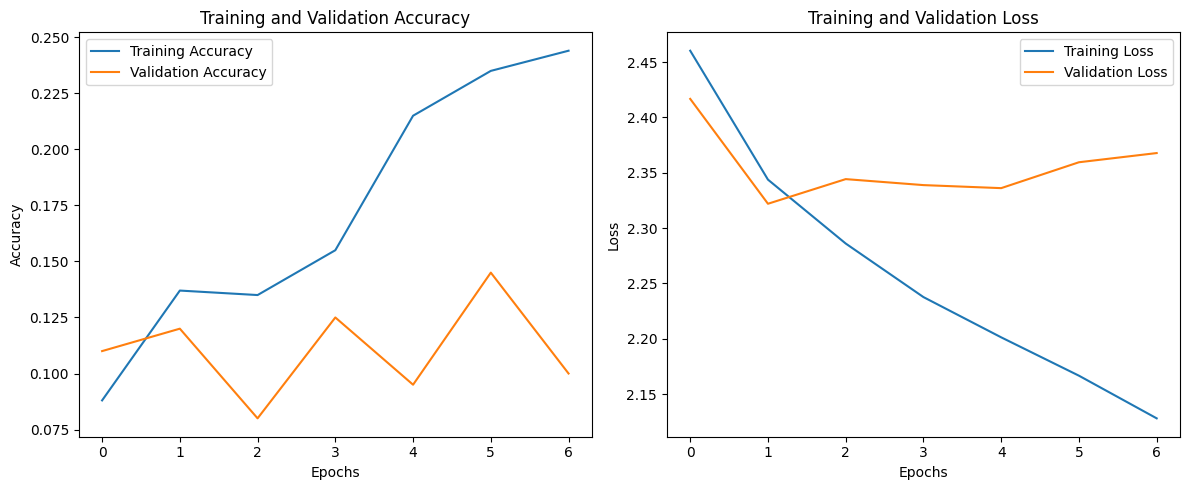

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
import matplotlib.pyplot as plt

# Access history metrics correctly
acc = history.history['accuracy']            # Training accuracy
val_acc = history.history['val_accuracy']    # Validation accuracy
loss = history.history['loss']               # Training loss
val_loss = history.history['val_loss']       # Validation loss

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print(history.history.keys())


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Simulated image data (replace these with your real image arrays)
# Example shapes: 1000 training images, 200 validation images, 200 test images
X_train = np.random.rand(1000, 128, 128, 3)
y_train = np.random.randint(0, 10, size=(1000,))
X_valid = np.random.rand(200, 128, 128, 3)
y_valid = np.random.randint(0, 10, size=(200,))
X_test = np.random.rand(200, 128, 128, 3)
y_test = np.random.randint(0, 10, size=(200,))

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Create tf.data datasets
batch_size = 100
datatrain = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
datavalid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)
datatest = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Define the model
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 50
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    callbacks=[early]
)

# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test data
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.1090 - loss: 2.3058 - val_accuracy: 0.0850 - val_loss: 2.3029
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.1486 - loss: 2.2833 - val_accuracy: 0.1100 - val_loss: 2.3072
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.1905 - loss: 2.2827 - val_accuracy: 0.1100 - val_loss: 2.3044
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.1879 - loss: 2.2765 - val_accuracy: 0.1100 - val_loss: 2.3005
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.1538 - loss: 2.2649 - val_accuracy: 0.1300 - val_loss: 2.3004
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.1811 - loss: 2.2650 - val_accuracy: 0.1100 - val_loss: 2.3126
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.2198 - loss: 2.2508 - val_accuracy: 0.1100 - val_loss: 2.3024
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.1216 - loss: 2.2358 - val_accuracy: 0.

In [ ]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step 
[[27  0  0  0  0  2  1  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  1  1  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  1 29  0  0]
 [ 0  0  3  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       1.00      1.00      1.00        30
           2       0.90      0.93      0.92        30
           3       1.00      1.00      1.00        30
           4       1.00      0.97      0.98        30
           5       0.94      0.97      0.95        30
           6       0.88      0.97      0.92        30
           7       0.94      0.97      0.95        30
           8       1.00      0.90      0.95        30
           9       1.00      1.00      1.00        30

    accuracy                     

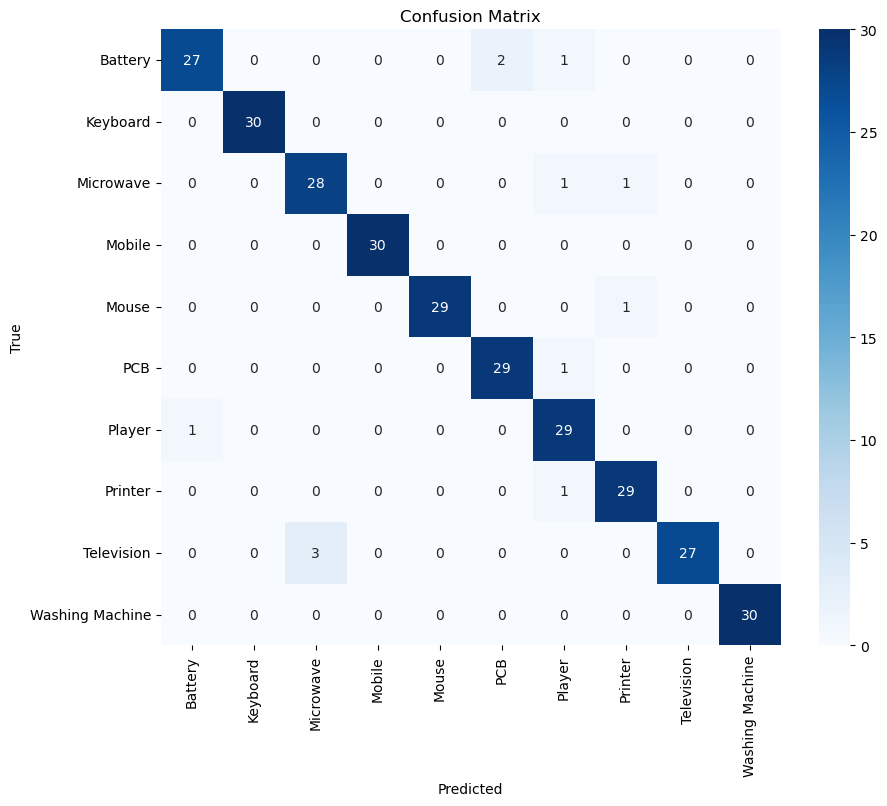

In [ ]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


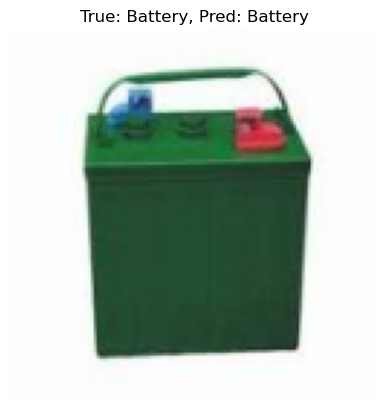

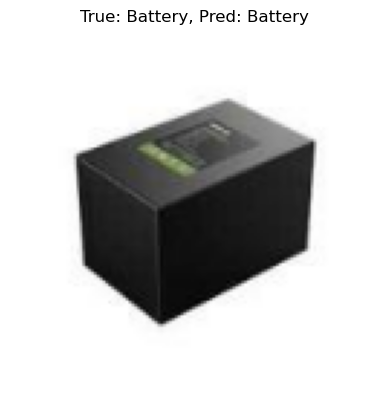

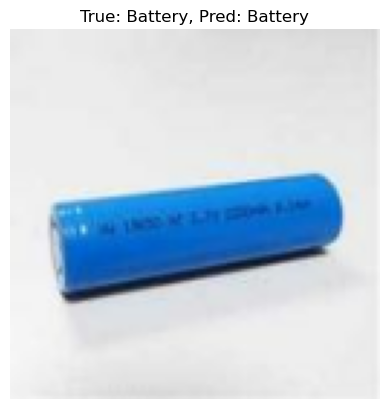

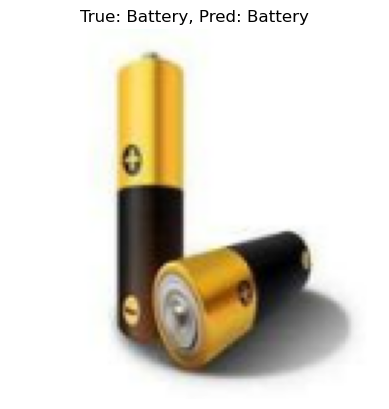

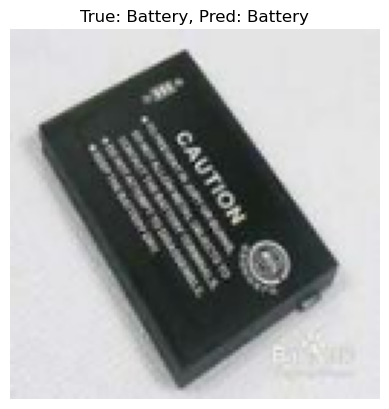

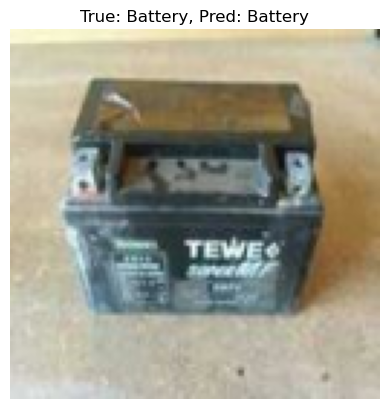

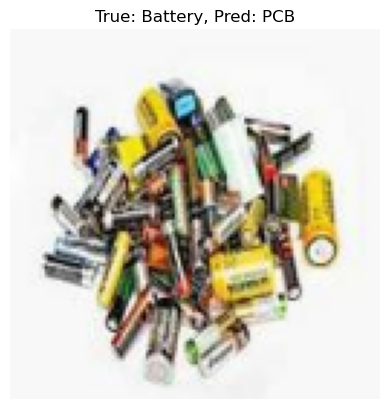

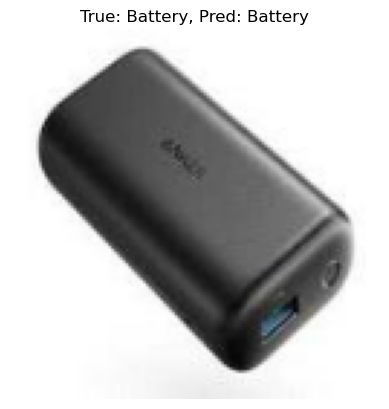

In [ ]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [ ]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [ ]:
!pip install gradio

### 🌐 Gradio Interface and Preprocessing
- `gr`: To build a web interface for the model.
- `PIL.Image`: For handling image input in Gradio.
- `preprocess_input`: Preprocessing method for EfficientNet.
- `load_model`: For loading a saved model for inference.


In [62]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [63]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9b9ee8e366554cd414.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
